## Dynamical Hamiltonian

In [1]:
import os
from torch import nn
from modules import utils
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)
logging.getLogger('numba').setLevel(logging.WARNING)
import torch
import torch.multiprocessing as mp
from modules.utils import CONFIG_PATH
from modules.data_loader import StaticDataset,DynamicDataset
from torch.utils.data import DataLoader
from modules.models import BPNet, RNN_50_100
import numpy as np
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
import matplotlib.pylab as plt
assert torch.cuda.is_available(), "CPU training is not allowed."
hps = utils.get_hparams(config_path="dynamic_config.json")
os.environ['MASTER_ADDR'] = '127.0.0.1'
os.environ['MASTER_PORT'] = hps.train.port
n_gpus = torch.cuda.device_count()
dist.init_process_group(backend= 'gloo' if os.name == 'nt' else 'nccl', init_method='env://', world_size=n_gpus, rank=0)

INFO:torch.distributed.distributed_c10d:Added key: store_based_barrier_key:1 to store for rank: 0
INFO:torch.distributed.distributed_c10d:Rank 0: Completed store-based barrier for key:store_based_barrier_key:1 with 1 nodes.


In [2]:
def infer(test_loader,hps):
    model = torch.load(hps.infer.model_dir)  # 读取模型
    model = DDP(model, device_ids=[0], find_unused_parameters=True)
    model.eval()
    inputs, outputs, infers = None, None, None
    for batch_idx, items in enumerate(test_loader):
        input_data, output_data = items
        input_data = input_data.cuda(0, non_blocking=True)
        output_data = output_data.cuda(0, non_blocking=True)
        if batch_idx == 0:
            infers = model(input_data)
            inputs = input_data
            outputs = output_data
        else:
            infers = torch.cat([infers, model(input_data)], dim=0)
            inputs = torch.cat([inputs, input_data], dim=0)
            outputs = torch.cat([outputs, output_data], dim=0)
    return inputs,outputs,infers


### HZZX


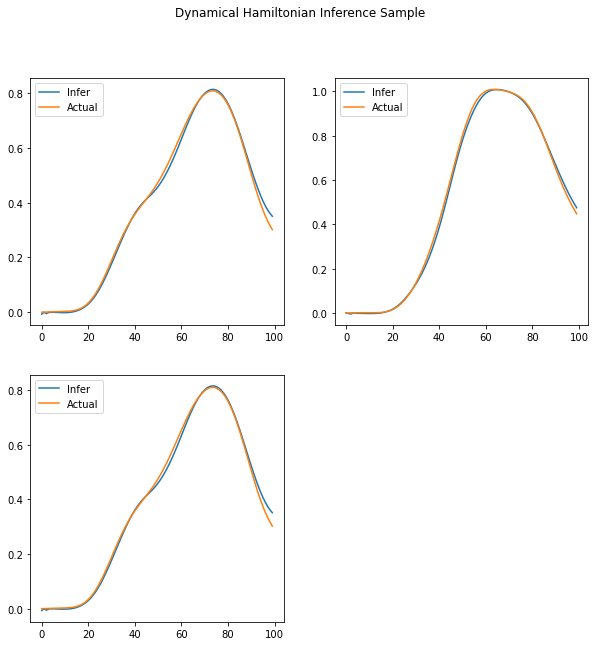

In [3]:
num_workers = 5 if mp.cpu_count() > 4 else mp.cpu_count()
test_dataset = DynamicDataset(hps,"test")
test_loader = DataLoader(test_dataset, num_workers=num_workers, shuffle=False, pin_memory=True,
                             batch_size=hps.infer.batch_size)
inputs,outputs,infers = infer(test_loader,hps)
infers = infers.cpu().detach().numpy()
outputs = outputs.cpu().detach().numpy()
randindex = torch.randint(0,inputs.shape[0],[1])
plt.figure(figsize=(10, 10))
plt.suptitle("Dynamical Hamiltonian Inference Sample")
for i in range(3):
    plt.subplot(2, 2, i+1)
    plt.plot(infers[randindex,:,i],label='Infer')
    plt.plot(outputs[randindex,:,i],label='Actual')
    plt.legend()
plt.show()
